# LM-FBS with SDynPy
This notebook couples the 2DOF systems together with LM-FBS using pre-existing methods in SDynPy to eliminate as much manual bookkeeping as possible. As a reminder, a graphic of the FBS coupling is shown below, where system A is on the left, system B is on the right, and the coupled system is in the center. 

![Two_DOF_System](./Images/TwoMassSystem.svg)

## LM-FBS SDynPy Functions
SDynPy implements the LM-FBS method with two different methods for the `TransferFunctionArray` object, using the standard formulation:

$$
\begin{bmatrix}H^{ab}\end{bmatrix}=\begin{bmatrix}\overline{H}^{ab}\end{bmatrix}-\begin{bmatrix}\overline{H}^{ab}\end{bmatrix}\begin{bmatrix}B_{ref}\end{bmatrix}^T\begin{pmatrix}\begin{bmatrix}B_{res}\end{bmatrix}\begin{bmatrix}\overline{H}^{ab}\end{bmatrix}\begin{bmatrix}B_{ref}\end{bmatrix}^T\end{pmatrix}^+\begin{bmatrix}B_{res}\end{bmatrix}\begin{bmatrix}\overline{H}^{ab}\end{bmatrix}
$$

One method, named `substructure_by_constraint_matrix`, is somewhat manual and the user must supply a constraint matrix with an accompanying `CoordinateArray` to indicate the DOFs that the constraints are associated with. Note that this constraint matrix is slightly different than the B matrices that were used in the first LM-FBS example, since there should only be columns for the coupling DOFs rather than a column for every response and reference DOF (which is what is used in the typical LM-FBS formulation). 

The second method, named `substructure_by_coordinate` (where coordinate is the SDynPy term for DOF), is somewhat automatic since the user only needs to provide a `CoordinateArray` of DOF pairs to define the coupling DOFs. The function automatically builds the B-matrices from this `CoordinateArray` to perform the substructure coupling. 

This example will demonstrate substructuring with the `substructure_by_coordinate` method.

## Importing Information for the Example
This section imports the necessary packages and FRFs (as SDynPy `TransferFunctionArrays`) from the 2DOF example systems for the computation. These FRFs will be called `system_a_frfs`, `system_b_frfs`, and `coupled_system_frfs` based on the system that they are representative of. 

In [25]:
import numpy as np
import sdynpy as sdpy
import matplotlib.pyplot as plt

In [26]:
system_a_frfs = sdpy.TransferFunctionArray.load(r'./example_frfs/system_a_frfs.npz')
system_b_frfs = sdpy.TransferFunctionArray.load(r'./example_frfs/system_b_frfs.npz')
coupled_system_frfs = sdpy.TransferFunctionArray.load(r'./example_frfs/coupled_system_frfs.npz')

```{note}
The SDynPy substructuring methods automatically perform all the bookkeeping and reshaping that is needed to ensure that the FRFs are organized for the FBS process. As such, we do not need to review the FRF organization when using these methods. 
```

## Creating Block Diagonal FRFs
SDynPy has a dedicated function called `block_diagonal_frf` for creating a block diagonal FRF matrix from a tuple of `TransferFunctionArrays` (which is why there are extra parentheses in the method call). As such, the process for creating the block diagonal FRFs is reduced to a single line of code without the need for manual bookkeeping.

```{tip}
The `TransferFunctionArrays` cannot have conflicting response and reference DOF node numbers. If necessary, an offset should be added to the node numbers, either using a manual method or the `coordinate_node_offset` argument in the `block_diagonal_frf` function, to avoid errors in the substructuring function. A common framework for mitigating this type of conflict is to have one component be denoted as the "1000s" (i.e. [1001, 1002] for system A) and the second component be denoted as the "2000s" (i.e., [2003, 2004] for system A), where this pattern would repeat for any number of components. 
```

In [27]:
block_diagonal_frfs = sdpy.TransferFunctionArray.block_diagonal_frf((system_a_frfs, 
                                                                     system_b_frfs))

## Defining the Constraints
As previously mentioned the FBS coupling constraints are defined by generating DOF pairs as a SDynPy `CoordinateArray`, as shown below. 

```{note}
The `CoordinateArray` must be shaped (number of coupling constraints, 2), which is why the `newaxis` constant is used here. Otherwise, the SDynPy substructuring functions will not behave as expected. The `newaxis` constant would be unnecessary if the constraint `CoordinateArray` was created with multiple rows. 
```

In [28]:
coupling_dofs = sdpy.coordinate_array(string_array=['2X+', '3X+'])[np.newaxis,...]

## LM-FBS Coupling
The LM-FBS coupling is performed using the `substructure_by_coordinate` method for `TransferFunctionArrays`. Like the other FBS coupling examples, the raw FRF matrix from the SDynPy substructuring function has the same shape as the block diagonal FRF matrix with duplicate FRFs at the coupling DOFs. The equivalency of the duplicate FRFs is shown below with the `allclose` and graphical comparisons. 

In [29]:
raw_fbs_coupled_frfs = block_diagonal_frfs.substructure_by_coordinate(coupling_dofs)
print('The shape of the FBS coupled FRF matrix is: {:}'.format(raw_fbs_coupled_frfs.shape))

The shape of the FBS coupled FRF matrix is: (4, 4)


In [30]:
if np.allclose(raw_fbs_coupled_frfs[1, :].ordinate, raw_fbs_coupled_frfs[2, :].ordinate):
    print('All the FRFs with response DOFs two and three are the same')

All the FRFs with response DOFs two and three are the same


In [31]:
if np.allclose(raw_fbs_coupled_frfs[:, 1].ordinate, raw_fbs_coupled_frfs[:, 2].ordinate):
    print('All the FRFs with reference DOFs two and three are the same')

All the FRFs with reference DOFs two and three are the same


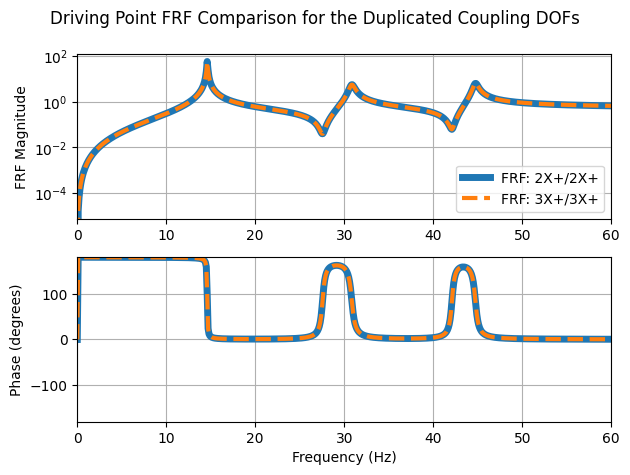

In [32]:
freq = system_a_frfs.ravel().abscissa[0]

fig, ax = plt.subplots(2)
ax[0].semilogy(freq, np.abs(raw_fbs_coupled_frfs[1, 1].ordinate), label='FRF: 2X+/2X+', 
               linewidth=5)
ax[0].semilogy(freq, np.abs(raw_fbs_coupled_frfs[2, 2].ordinate), label='FRF: 3X+/3X+', 
               linestyle='--', linewidth=3)
ax[0].set_xlim(left=freq[0], right=freq[-1])
ax[0].set_ylabel('FRF Magnitude')
ax[0].grid()
ax[0].legend()

ax[1].plot(freq, np.angle(raw_fbs_coupled_frfs[1, 1].ordinate)*180/np.pi, linewidth=5)
ax[1].plot(freq, np.angle(raw_fbs_coupled_frfs[2, 2].ordinate)*180/np.pi, linestyle='--', 
           linewidth=3)
ax[1].set_xlim(left=freq[0], right=freq[-1])
ax[1].set_ylim(top=180, bottom=-180)
ax[1].grid()
ax[1].set_ylabel('Phase (degrees)')
ax[1].set_xlabel('Frequency (Hz)')

fig.suptitle('Driving Point FRF Comparison for the Duplicated Coupling DOFs')
fig.set_tight_layout(tight='tight')

## Removing the Duplicated DOF
The duplicated FRFs can be removed by simply indexing the coupled FRF `TransferFunctionArray` with a `CoordinateArray` that defines the desired DOFs for the FRF matrix. The `CoordinateArray` is constructed with the `outer_product` function to appropriately arrange the response and reference DOFs. With the duplicated DOF removed, a simple equivalency comparison shows that the truth FRFs from the coupled system and LM-FBS coupling are exactly the same. This similarity is also shown in a graphical comparison of the driving point FRFs. 

In [33]:
coupled_frfs_response_dofs = sdpy.coordinate_array(string_array=['1X+', '2X+', '4X+'])
coupled_frfs_reference_dofs = sdpy.coordinate_array(string_array=['1X+', '2X+', '4X+'])
coupled_frf_dofs = sdpy.coordinate.outer_product(coupled_frfs_response_dofs, 
                                                 coupled_frfs_reference_dofs)

In [34]:
fbs_coupled_frfs_removed_dofs = raw_fbs_coupled_frfs[coupled_frf_dofs]

if np.allclose(coupled_system_frfs.ordinate, fbs_coupled_frfs_removed_dofs.ordinate):
    print('The FRFs from the LM-FBS coupling are exactly the same as the FRFs from the truth system')

The FRFs from the LM-FBS coupling are exactly the same as the FRFs from the truth system


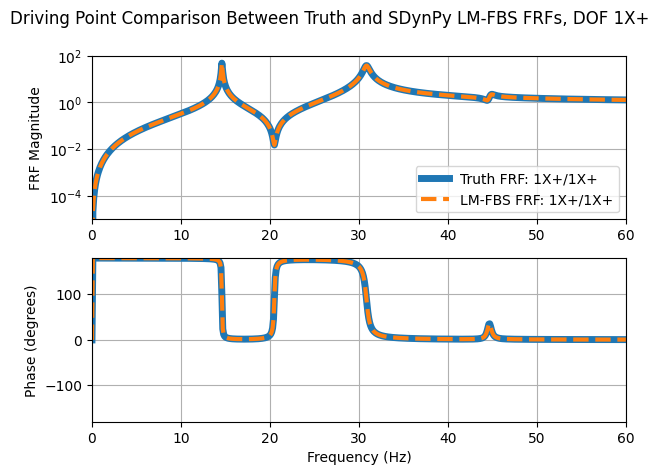

In [35]:
fig, ax = plt.subplots(2)
ax[0].semilogy(freq, np.abs(coupled_system_frfs[0, 0].ordinate), label='Truth FRF: 1X+/1X+', 
               linewidth=5)
ax[0].semilogy(freq, np.abs(fbs_coupled_frfs_removed_dofs[0, 0].ordinate), label='LM-FBS FRF: 1X+/1X+', 
               linestyle='--', linewidth=3)
ax[0].set_xlim(left=freq[0], right=freq[-1])
ax[0].set_ylabel('FRF Magnitude')
ax[0].grid()
ax[0].legend()

ax[1].plot(freq, np.angle(coupled_system_frfs[0, 0].ordinate)*180/np.pi, linewidth=5)
ax[1].plot(freq, np.angle(fbs_coupled_frfs_removed_dofs[0, 0].ordinate)*180/np.pi, 
           linestyle='--', linewidth=3)
ax[1].set_xlim(left=freq[0], right=freq[-1])
ax[1].set_ylim(top=180, bottom=-180)
ax[1].grid()
ax[1].set_ylabel('Phase (degrees)')
ax[1].set_xlabel('Frequency (Hz)')

fig.suptitle('Driving Point Comparison Between Truth and SDynPy LM-FBS FRFs, DOF 1X+')
fig.set_tight_layout(tight='tight')

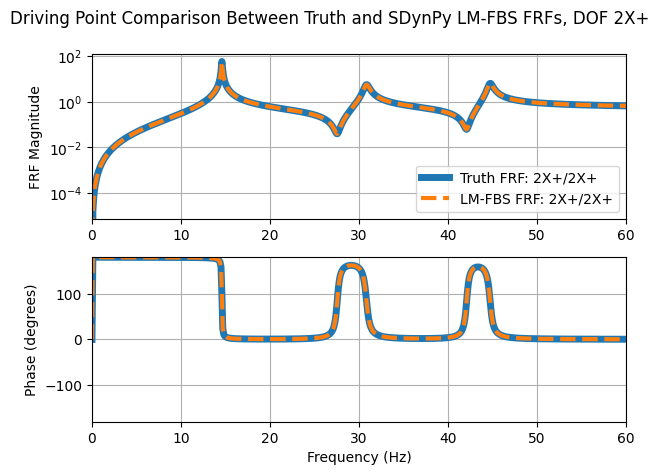

In [36]:
fig, ax = plt.subplots(2)
ax[0].semilogy(freq, np.abs(coupled_system_frfs[1, 1].ordinate), label='Truth FRF: 2X+/2X+', 
               linewidth=5)
ax[0].semilogy(freq, np.abs(fbs_coupled_frfs_removed_dofs[1, 1].ordinate), label='LM-FBS FRF: 2X+/2X+', 
               linestyle='--', linewidth=3)
ax[0].set_xlim(left=freq[0], right=freq[-1])
ax[0].set_ylabel('FRF Magnitude')
ax[0].grid()
ax[0].legend()

ax[1].plot(freq, np.angle(coupled_system_frfs[1, 1].ordinate)*180/np.pi, linewidth=5)
ax[1].plot(freq, np.angle(fbs_coupled_frfs_removed_dofs[1, 1].ordinate)*180/np.pi, 
           linestyle='--', linewidth=3)
ax[1].set_xlim(left=freq[0], right=freq[-1])
ax[1].set_ylim(top=180, bottom=-180)
ax[1].grid()
ax[1].set_ylabel('Phase (degrees)')
ax[1].set_xlabel('Frequency (Hz)')

fig.suptitle('Driving Point Comparison Between Truth and SDynPy LM-FBS FRFs, DOF 2X+')
fig.set_tight_layout(tight='tight')

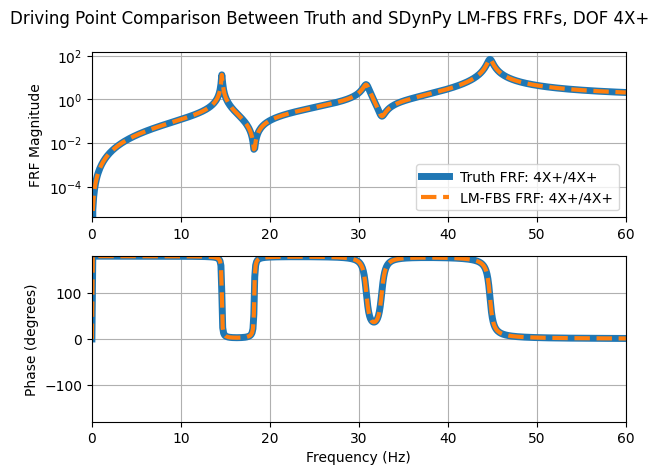

In [37]:
fig, ax = plt.subplots(2)
ax[0].semilogy(freq, np.abs(coupled_system_frfs[2, 2].ordinate), label='Truth FRF: 4X+/4X+', 
               linewidth=5)
ax[0].semilogy(freq, np.abs(fbs_coupled_frfs_removed_dofs[2, 2].ordinate), label='LM-FBS FRF: 4X+/4X+', 
               linestyle='--', linewidth=3)
ax[0].set_xlim(left=freq[0], right=freq[-1])
ax[0].set_ylabel('FRF Magnitude')
ax[0].grid()
ax[0].legend()

ax[1].plot(freq, np.angle(coupled_system_frfs[2, 2].ordinate)*180/np.pi, linewidth=5)
ax[1].plot(freq, np.angle(fbs_coupled_frfs_removed_dofs[2, 2].ordinate)*180/np.pi, 
           linestyle='--', linewidth=3)
ax[1].set_xlim(left=freq[0], right=freq[-1])
ax[1].set_ylim(top=180, bottom=-180)
ax[1].grid()
ax[1].set_ylabel('Phase (degrees)')
ax[1].set_xlabel('Frequency (Hz)')

fig.suptitle('Driving Point Comparison Between Truth and SDynPy LM-FBS FRFs, DOF 4X+')
fig.set_tight_layout(tight='tight')

## Conclusions
This notebook has shown how functions in SDynPy can simplify the FBS process to a few lines of code with simple, compact, and universal functions that automatically perform the bookkeeping. Note that several other software packages exist to aid in the substructuring process. Like other engineering problems the practitioner to choose a software package that matches their requirements. 

```{warning}
Regardless of the chosen software package, it is highly recommended that the practitioner use (tested and validated) software to automatically perform the bookkeeping and FRF organization, since manual bookkeeping is error prone and can invalidate the substructuring results. Most real substructuring problems will not have validation data. As such, confidence in the substructuring results is primarily built through confidence in the process that was used for the substructuring as well as the judgement of subject matter experts.
```  